In [41]:
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from transformers import pipeline
import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import random
import nltk
nltk.download('inaugural')

[nltk_data] Downloading package inaugural to
[nltk_data]     C:\Users\ziadw\AppData\Roaming\nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

## Data

In [42]:
# docs = []
# # Initialize the text generation pipeline with the desired model
# generator = pipeline('text-generation', model='gpt2')

# # Encode input prompts text and generate text
# prompts = [
# "egyptian pyramids",
# "Olympics",
# "artfial intelligence",
# "quantum physics",
# ]
# for prompt in tqdm.tqdm(prompts):
#     text = generator(prompt, max_length=1000, num_return_sequences=1,truncation=True,pad_token_id=50256)
#     docs.append(text[0]['generated_text'])
#     print(text[0]['generated_text'],file=open(f"{prompt}.txt", "w"))
def generate_random_document():
    words = nltk.corpus.inaugural.words()
    num_words = random.randint(500, 500)  
    random_words = ' '.join(random.choices(words, k=num_words))
    return random_words
def generate_documents(n_documents):
    documents = []
    for _ in range(n_documents):
        doc = generate_random_document()
        documents.append(doc)
    return documents

docs = generate_documents(3)

## Processing on Data

In [43]:
def data_Preprocessing(text):
    # Step 1: Cleaning data from each symbol or character doesn’t contain to the data.
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Step 2: Normalization: make all the data to lower case
    normalized_text = cleaned_text.lower()

    # Step 3: Tokenization: split the data to words
    words = word_tokenize(normalized_text)

    # Step 4: Lemmatization or Stemming: return each word to origin.
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # Step 5: Stop words: remove stop words from the data.
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in lemmatized_words if word not in stop_words]
    return filtered_words

In [44]:
processed_docs = [data_Preprocessing(doc) for doc in docs]

## Unique Words

In [45]:
def print_unique_words(filtered_words):
    unique_words = set(filtered_words) # Get unique words 
    word_count = Counter(filtered_words) # Count the words
    print("Unique words:", len(unique_words))
    print('-'*50)
    for i, word in enumerate(unique_words):
        print(f'{word}[{word_count[word]}]', end="\n" if (i + 1) % 15 == 0 else " ")
    print('\n' + '-'*50)

In [46]:
for i, doc in enumerate(processed_docs):
    print(f"Document {i+1}")
    print_unique_words(doc)
    print()

Document 1
Unique words: 195
--------------------------------------------------
first[1] place[1] mindful[1] precious[1] abundant[1] individual[1] child[1] understand[1] consequent[1] improvement[1] locality[1] perfectly[1] effort[1] better[1] maintain[1]
ceremony[1] honor[1] united[1] life[1] necessity[1] seek[1] appointment[1] distributer[1] founding[1] would[1] country[1] initiative[1] unselfish[1] order[1] matter[1]
goal[1] meant[1] read[1] preserved[1] nomination[1] bestowed[1] forced[1] magistrate[1] devolved[1] head[1] turn[1] tomorrow[1] much[2] economy[1] resource[1]
enough[1] thing[1] act[1] left[1] afraid[1] force[1] strive[1] basis[1] new[1] story[2] arduous[1] already[1] came[1] understanding[1] carried[1]
leaf[1] firm[1] serve[1] declining[1] smaller[1] shall[2] longer[1] house[1] mindfulness[1] walk[1] government[1] bound[1] member[1] discretion[1] good[1]
st[1] people[2] render[1] identified[1] may[1] history[1] soil[2] example[1] sense[1] u[2] growing[1] attachment[1] 

In [47]:
def most_common_words(filtered_words, title):
    word_count = Counter(filtered_words) # Count the words
    # Get the most common words and their counts
    top_words = word_count.most_common(10) # Get the top 10 words
    words = [word[0] for word in top_words] # Get the words
    counts = [word[1] for word in top_words] # Get the counts

    # Bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title("Most common words in " + str(title+1))
    plt.xlabel("Words")
    plt.ylabel("Count")
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()

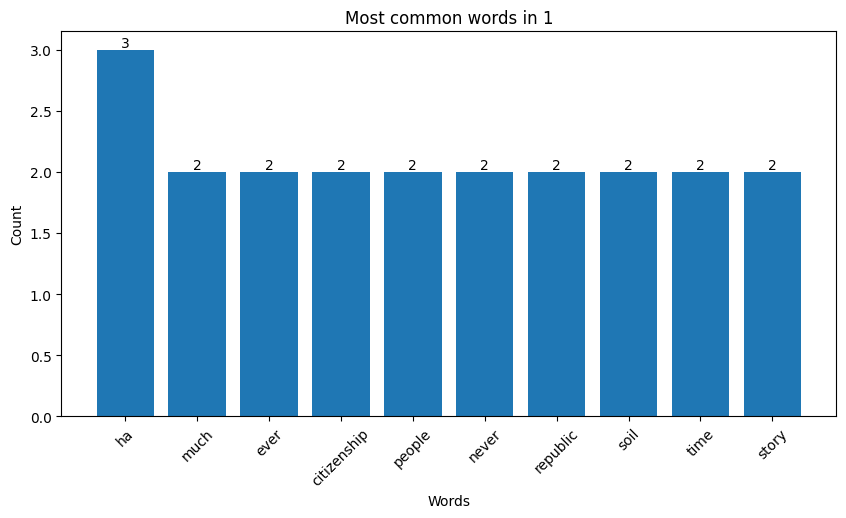

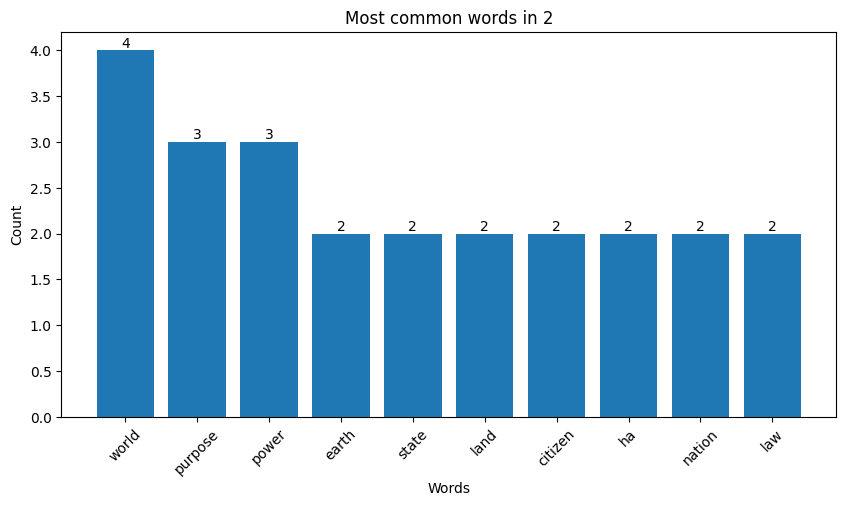

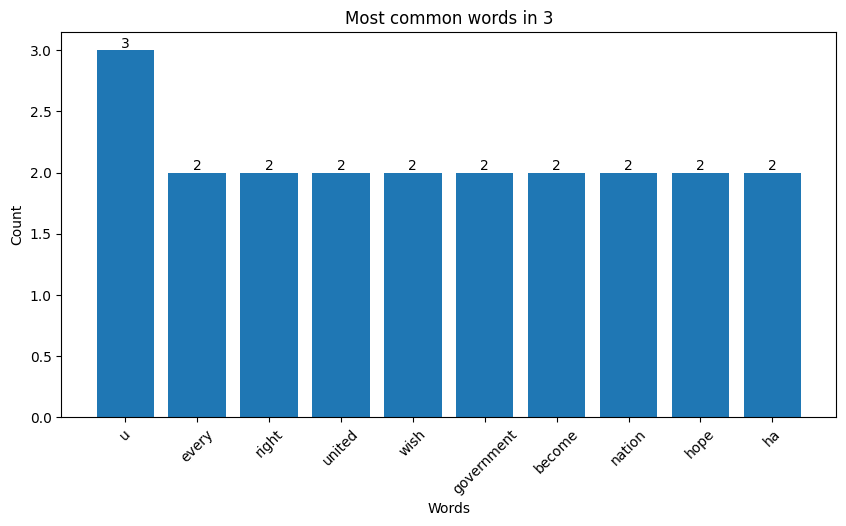

In [48]:
for i, doc in enumerate(processed_docs):
    most_common_words(doc, i)
    print()

## TF-IDF From Scratch

In [49]:
from collections import defaultdict
import math

# Step 1: Get TF for each word for all documents
def get_tf(processed_docs):
    tfs = []
    for doc in processed_docs:
        total_words = len(doc)
        tf = defaultdict(int)
        for word in doc:
            tf[word] += 1 / total_words 
        tfs.append(tf)
    return tfs

# Step 2: Get IDF for each word
def get_idf(processed_docs):
    total_docs = len(processed_docs)
    idfs = defaultdict(int) 
    for doc in processed_docs:
        for word in set(doc):
            idfs[word] += 1
    for word in idfs:
        idfs[word] = math.log((1+total_docs) / (1+idfs[word]) )+ 1
    return idfs

# Step 3: Multiply TF and IDF for each word for all documents
def get_tfidf(tfs, idfs):
    tfidfs = []
    for tf in tfs:
        tfidf = {word: tf[word] * idfs[word] for word in tf}
        tfidfs.append(tfidf)
    return tfidfs

# Step 4: Get normalized TF-IDF for each word for all documents
def get_normalized_tfidf(tfidfs):
    normalized_tfidfs = []
    for tfidf in tfidfs:
        norm = np.linalg.norm(list(tfidf.values()))
        normalized_tfidf = {word: tfidf_val / norm for word, tfidf_val in tfidf.items()}
        normalized_tfidfs.append(normalized_tfidf)
    return normalized_tfidfs

# Step 5: Get the feature vector for each document
def get_feature_vectors(processed_docs, normalized_tfidfs):
    feature_vectors = []
    unique_words = set(word for doc in processed_docs for word in doc) 
    for tfidf in normalized_tfidfs:
        feature_vector = [tfidf[word] if word in tfidf else 0 for word in unique_words]
        feature_vectors.append(feature_vector)
    return feature_vectors


tfs = get_tf(processed_docs)
idfs = get_idf(processed_docs)
tfidfs = get_tfidf(tfs, idfs)
normalized_tfidfs = get_normalized_tfidf(tfidfs)
feature_vectors = get_feature_vectors(processed_docs, normalized_tfidfs)


In [50]:
# print the feature vector for each document
for i, feature_vector in enumerate(feature_vectors):
    print(f"Document {i+1}")
    print(feature_vector)
    print()
    

Document 1
[0.07196777287763481, 0, 0.07196777287763481, 0.07196777287763481, 0, 0, 0, 0, 0, 0.05473334627540422, 0.05473334627540422, 0, 0, 0, 0.07196777287763481, 0, 0.07196777287763481, 0.07196777287763481, 0.07196777287763481, 0.05473334627540422, 0, 0.07196777287763481, 0, 0, 0.10946669255080844, 0, 0, 0, 0.07196777287763481, 0, 0, 0, 0, 0, 0.05473334627540422, 0, 0, 0, 0, 0, 0.0850106520023075, 0, 0, 0, 0, 0.07196777287763481, 0.07196777287763481, 0.05473334627540422, 0.05473334627540422, 0.07196777287763481, 0, 0, 0.04250532600115375, 0, 0, 0, 0, 0, 0, 0.04250532600115375, 0.07196777287763481, 0, 0, 0.07196777287763481, 0, 0, 0, 0, 0.07196777287763481, 0, 0, 0.07196777287763481, 0, 0, 0.07196777287763481, 0, 0, 0.07196777287763481, 0, 0.04250532600115375, 0.04250532600115375, 0, 0, 0, 0, 0.07196777287763481, 0, 0, 0, 0, 0, 0, 0, 0.10946669255080844, 0, 0, 0.14393554575526962, 0.05473334627540422, 0, 0, 0.05473334627540422, 0.05473334627540422, 0.07196777287763481, 0, 0, 0, 0, 0,

## Use sklearn to calculate TF-IDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the processed_docs list to a string
processed_docs_str = [' '.join(doc) for doc in processed_docs]

# Create the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents
X = vectorizer.fit_transform(processed_docs_str)

# Convert the X to an array
X = X.toarray()

# Print the feature vector for each document
for i, x in enumerate(X):
    print(f"Document {i+1}")
    print(x)
    print()

Document 1
[0.07222924 0.         0.         0.         0.07222924 0.
 0.         0.07222924 0.07222924 0.07222924 0.         0.07222924
 0.07222924 0.         0.         0.07222924 0.         0.07222924
 0.07222924 0.         0.0549322  0.         0.         0.0549322
 0.0549322  0.         0.         0.         0.         0.
 0.07222924 0.         0.         0.         0.         0.07222924
 0.         0.07222924 0.07222924 0.         0.         0.
 0.07222924 0.07222924 0.         0.         0.07222924 0.07222924
 0.         0.         0.         0.         0.07222924 0.07222924
 0.07222924 0.         0.07222924 0.         0.         0.
 0.07222924 0.         0.07222924 0.07222924 0.         0.
 0.14445848 0.         0.         0.         0.         0.07222924
 0.         0.         0.         0.         0.         0.07222924
 0.07222924 0.07222924 0.         0.         0.07222924 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.07222

## Cosine Similarity 

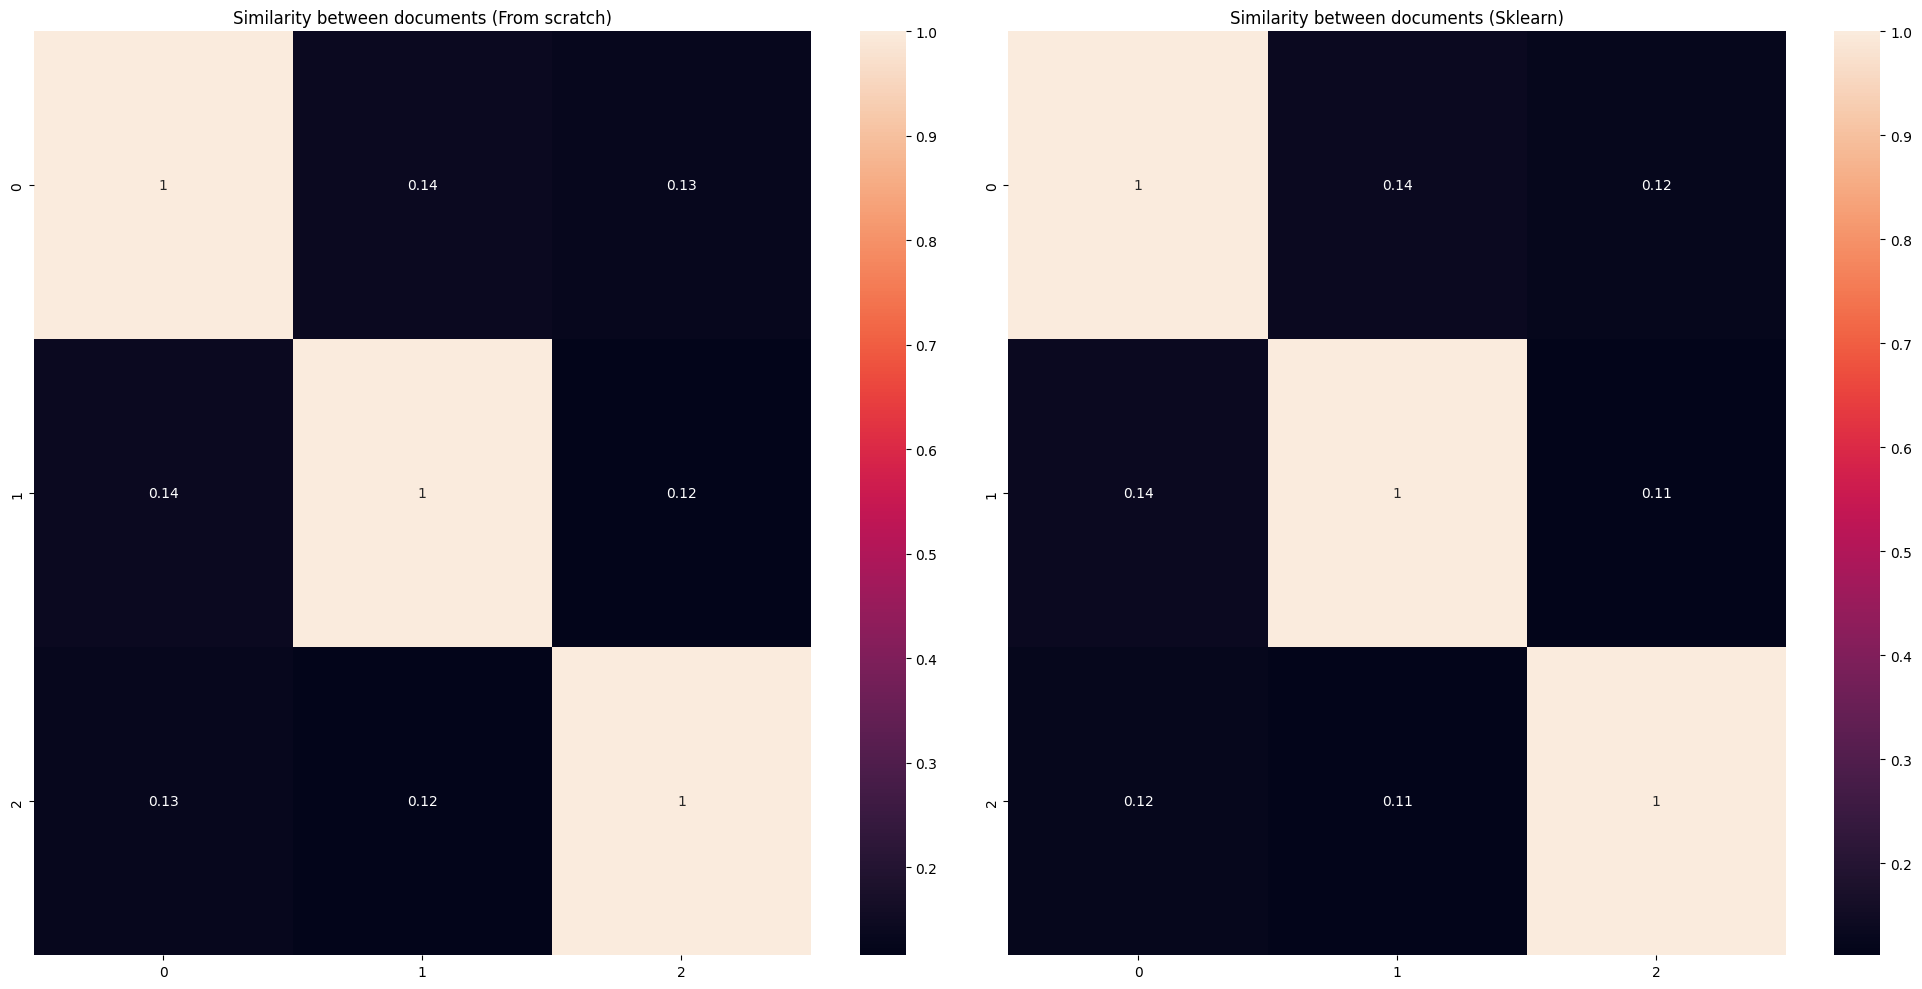

In [52]:
X = np.array(X)
# get the similarity between each pair of documents
similaritieSklearn = cosine_similarity(X)

feature_vectors = np.array(feature_vectors)
# get the similarity between each pair of documents
similaritiesFromScratch = cosine_similarity(feature_vectors)

# make a figer for two methods of similarity
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(similaritiesFromScratch, annot=True,)
plt.title("Similarity between documents (From scratch)")

plt.subplot(1, 2, 2)
sns.heatmap(similaritieSklearn, annot=True,)
plt.title("Similarity between documents (Sklearn)")

plt.tight_layout()
plt.show()

In [53]:
# error between the two methods
error = np.mean(np.abs(similaritiesFromScratch - similaritieSklearn))
print("Error between the two methods:", error)

Error between the two methods: 0.0035515599923771532
